# Data analysis

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids

In [2]:
last = pd.read_csv("data/last.txt", sep=";")
last["shape"] = last["shape"].apply(lambda x: x.split("-")[0])
last["sensor.config"] = last["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
last["step"] = last["step"].apply(lambda x: "step" if x == "T" else "no-step")
last["$f_c$"] = last["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")
last.head()

,experiment.name,seed,terrain,shape,sensor.config,mapper,transformation,solver,episode.time,episode.transient.time,...,best.fitness.footprints.spectra..27.,best.fitness.footprints.spectra..28.,best.fitness.footprints.spectra..29.,best.fitness.footprints.spectra..30.,best.fitness.footprints.spectra..31.,best.solution.serialized,architecture,step,controller,$f_c$
0,snn-centralized,0,flat,biped,rich,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,34.805719,20.769799,12.168933,8.184847,8.464860,H4sIAAAAAAAA/+yda4+l13Gd/0t/bg32/cJPESQZECBRjq...,Centralized,no-step,LIF,$60Hz$
1,snn-centralized,0,flat,biped,rich,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,24.878136,24.908329,15.143474,14.780565,12.787218,H4sIAAAAAAAA/+ydfW+t13Hdvwv/poj9/qK/atgOasCWW0...,Centralized,no-step,LIF-H,$60Hz$
2,snn-centralized,0,flat,biped,rich,brainCentralized<mlp;nIL=1;r=1,identity,ES;nPop=36;nEval=20000,30,5,...,35.637301,24.737519,16.411284,8.447346,5.256231,H4sIAAAAAAAA/+yda49m1XGF/0t/7mnt+4VPQQYrSARbgC...,Centralized,no-step,MLP,$60Hz$
3,snn-centralized,0,flat,biped,touch,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,33.362417,16.838530,10.919022,10.968093,13.247009,H4sIAAAAAAAA/+yZSW8bNxSA/8ucJwPui041vAAGbDm11K...,Centralized,no-step,LIF,$60Hz$
4,snn-centralized,0,flat,biped,touch,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,22.230475,25.129133,18.676639,14.849033,9.218062,H4sIAAAAAAAA/+xaW08bORT+L/M8jHy/5GkRUC0ShS5k25...,Centralized,no-step,LIF-H,$60Hz$


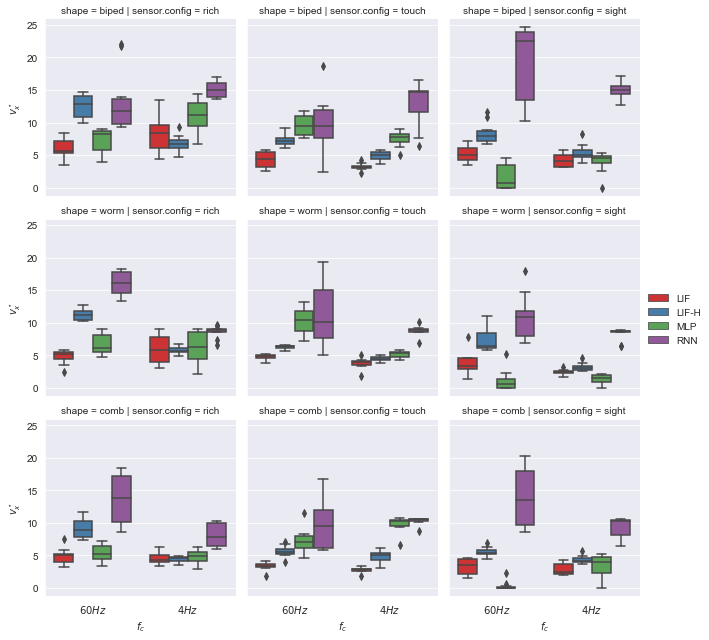

In [3]:
g = sns.FacetGrid(last, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="best.fitness.fitness", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$v_x^\star$")
plt.show()

In [4]:
alpha = 0.05 / 16

shapes = last["shape"].unique()
sensors = last["sensor.config"].unique()
steps = last["step"].unique()
controllers = last["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = last[(last["shape"] == shape) & (last["sensor.config"] == sensor) & (last["step"] == step) & (
                last["controller"] == c1)]["best.fitness.fitness"].to_list()
            v2 = last[(last["shape"] == shape) & (last["sensor.config"] == sensor) & (last["step"] == step) & (
                last["controller"] == c2)]["best.fitness.fitness"].to_list()
            if mannwhitneyu(v1, v2, alternative="greater").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "LIF", "LIF-H"]]
p_df = p_df.reindex(["MLP", "RNN", "LIF", "LIF-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["LIF"] + p_df["LIF-H"]
p_df

c2,MLP,RNN,LIF,LIF-H,total
c1,,,,,
MLP,0,0,6,5,11
RNN,12,0,17,14,43
LIF,4,0,0,0,4
LIF-H,7,0,13,0,20


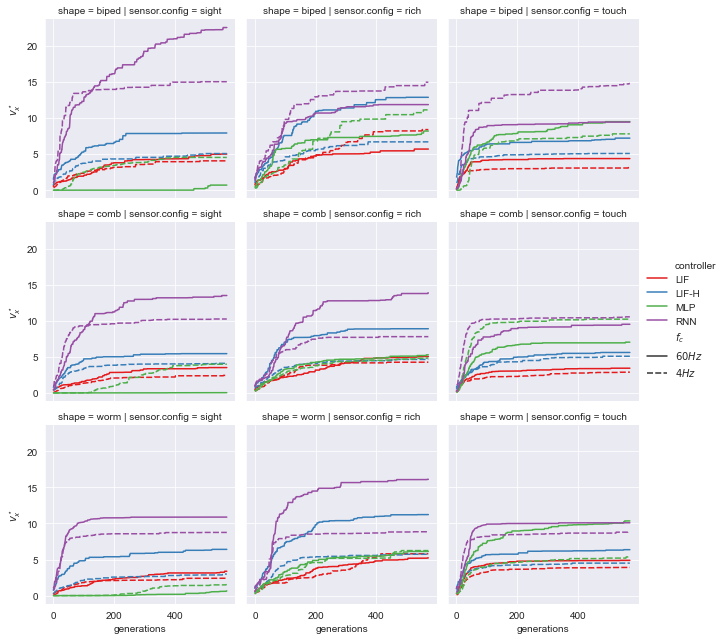

In [5]:
best = pd.read_csv("data/best-evo.txt", sep=";")
best["shape"] = best["shape"].apply(lambda x: x.split("-")[0])
best["sensor.config"] = best["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
best["step"] = best["step"].apply(lambda x: "step" if x == "T" else "no-step")
best["$f_c$"] = best["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")

g = sns.FacetGrid(best, col="sensor.config", row="shape")
g.map_dataframe(sns.lineplot, x="iterations", y="median", hue="controller", palette="Set1", style="$f_c$")
g.add_legend()
g.set_xlabels("generations")
g.set_ylabels("$v_x^\star$")
plt.show()

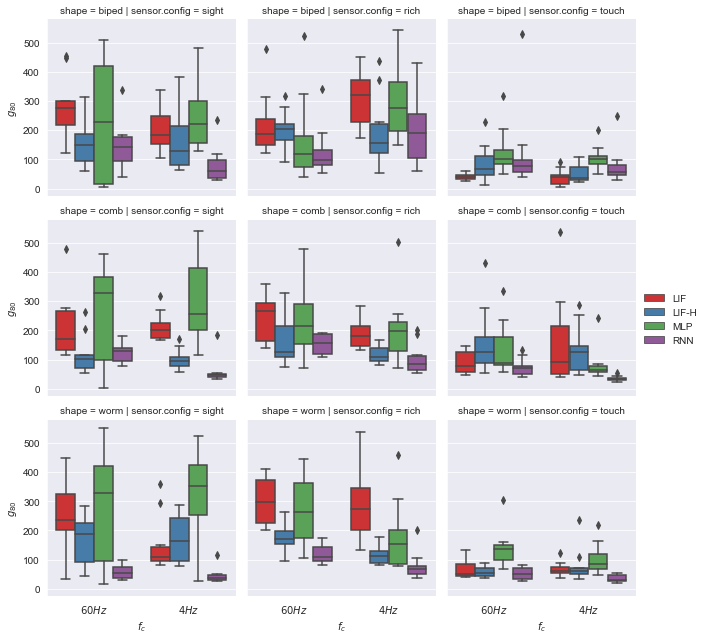

In [6]:
efficiency = pd.read_csv("data/eff-80.txt", sep=";")
efficiency["shape"] = efficiency["shape"].apply(lambda x: x.split("-")[0])
efficiency["sensor.config"] = efficiency["sensor.config"].apply(
  lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
efficiency["step"] = efficiency["step"].apply(lambda x: "step" if x == "T" else "no-step")
efficiency["$f_c$"] = efficiency["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")

g = sns.FacetGrid(efficiency, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="iterations", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$g_{80}$")
plt.show()

In [7]:
alpha = 0.05 / 16

shapes = efficiency["shape"].unique()
sensors = efficiency["sensor.config"].unique()
steps = efficiency["step"].unique()
controllers = efficiency["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = efficiency[(efficiency["shape"] == shape) & (efficiency["sensor.config"] == sensor) & (
                efficiency["step"] == step) & (efficiency["controller"] == c1)]["iterations"].to_list()
            v2 = efficiency[(efficiency["shape"] == shape) & (efficiency["sensor.config"] == sensor) & (
                efficiency["step"] == step) & (efficiency["controller"] == c2)]["iterations"].to_list()
            if mannwhitneyu(v1, v2, alternative="less").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "LIF", "LIF-H"]]
p_df = p_df.reindex(["MLP", "RNN", "LIF", "LIF-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["LIF"] + p_df["LIF-H"]
p_df

c2,MLP,RNN,LIF,LIF-H,total
c1,,,,,
MLP,0,0,0,0,0
RNN,7,0,9,5,21
LIF,3,1,0,0,4
LIF-H,3,0,4,0,7


In [8]:
rho = pd.read_csv("data/validation.txt", sep=";")
rho["shape"] = rho["shape"].apply(lambda x: x.split("-")[0])
rho["sensor.config"] = rho["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
rho["step"] = rho["step"].apply(lambda x: "step" if x == "T" else "no-step")
rho["$f_c$"] = rho["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")
rho = rho.groupby(["seed", "controller", "sensor.config", "shape", "step"])[
  "validation.outcome.velocity"].mean().reset_index()
rho = pd.merge(rho, last[["seed", "controller", "sensor.config", "shape", "step", "best.fitness.fitness", "$f_c$"]])
rho["rho"] = rho["validation.outcome.velocity"] / rho["best.fitness.fitness"]
rho.head()

,seed,controller,sensor.config,shape,step,validation.outcome.velocity,best.fitness.fitness,$f_c$,rho
0,0,LIF,rich,biped,no-step,1.389570,4.840638,$60Hz$,0.287063
1,0,LIF,rich,biped,step,2.487316,6.380884,$4Hz$,0.389807
2,0,LIF,rich,comb,no-step,1.946057,5.114951,$60Hz$,0.380464
3,0,LIF,rich,comb,step,1.622089,4.176715,$4Hz$,0.388365
4,0,LIF,rich,worm,no-step,2.805123,5.682633,$60Hz$,0.493631


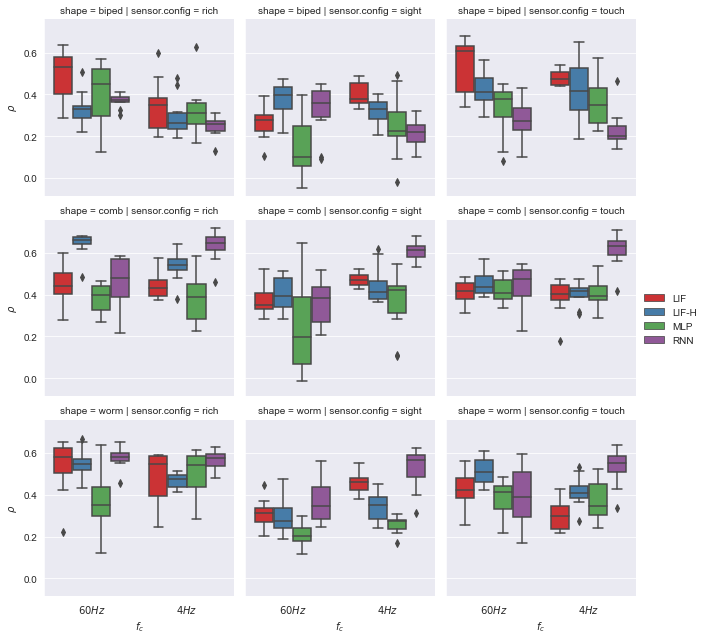

In [9]:
g = sns.FacetGrid(rho, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="rho", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$\\rho$")
plt.show()

In [10]:
alpha = 0.05 / 16

shapes = rho["shape"].unique()
sensors = rho["sensor.config"].unique()
steps = rho["step"].unique()
controllers = rho["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = rho[(rho["shape"] == shape) & (rho["sensor.config"] == sensor) & (rho["step"] == step) & (
                rho["controller"] == c1)]["rho"].to_list()
            v2 = rho[(rho["shape"] == shape) & (rho["sensor.config"] == sensor) & (rho["step"] == step) & (
                rho["controller"] == c2)]["rho"].to_list()
            if mannwhitneyu(v1, v2, alternative="greater").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "LIF", "LIF-H"]]
p_df = p_df.reindex(["MLP", "RNN", "LIF", "LIF-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["LIF"] + p_df["LIF-H"]
p_df

c2,MLP,RNN,LIF,LIF-H,total
c1,,,,,
MLP,0,0,0,0,0
RNN,7,0,4,4,15
LIF,2,3,0,2,7
LIF-H,4,4,2,0,10


In [11]:
pca = PCA(n_components=2)
spectrum_columns = [c for c in last.columns if c.startswith("best.fitness.center.")]
dfs = []

for shape in last["shape"].unique():
  tmp = last[last["shape"] == shape].copy()
  x = tmp.loc[:, spectrum_columns].values
  x = StandardScaler().fit_transform(x)
  pc = pca.fit_transform(x)
  tmp["pc1"] = pc[:, 0]
  tmp["pc2"] = pc[:, 1]
  tmp["cluster"] = KMedoids(3).fit(x).labels_
  dfs.append(tmp)

last_extra = pd.concat(dfs, ignore_index=True)

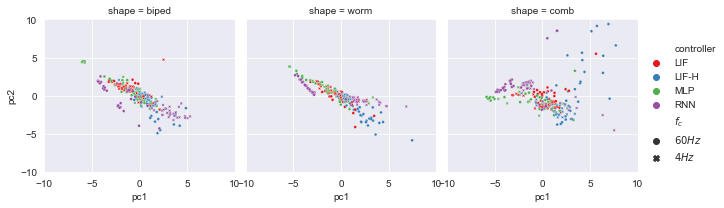

In [12]:
g = sns.FacetGrid(last_extra, col="shape")
g.map_dataframe(sns.scatterplot, x="pc1", y="pc2", hue="controller", style="$f_c$", s=8, palette="Set1")
g.set(xlim=(-10, 10), ylim=(-10, 10))
g.add_legend()
plt.show()

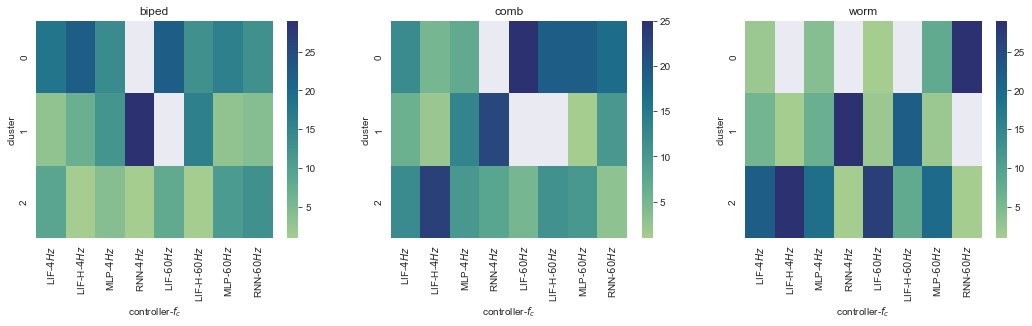

In [13]:
last_heatmap = last_extra.groupby(["shape", "$f_c$", "controller", "cluster"])["pc1"].count().reset_index(name="count")

fig, axs = plt.subplots(figsize=(18, 4), nrows=1, ncols=3)
for i, shape in enumerate(last_heatmap["shape"].unique()):
  sns.heatmap(last_heatmap[last_heatmap["shape"] == shape]
              .pivot(columns=["controller", "$f_c$"], index="cluster", values="count"), ax=axs[i], cmap="crest")
  axs[i].set_title(shape)